### Prepare

In [1]:
import torch
torch.cuda.empty_cache()

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
import os
root_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/"

### Define Tokenizer

In [3]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Default

In [4]:
from PIL import Image
from utils import model_loader
img = Image.open("./images/test_image/bottle.jpg").convert("RGB")

- Load statedict

In [5]:
kwargs = {}
diffusion_state_dict = torch.load(os.path.join(root_path, "favorfit_base.pth"))

- For LORA

In [6]:
kwargs["is_lora"] = True
lora_state_dict = torch.load(os.path.join(root_path, "lora", "favorfit_lora.pth"))
diffusion_state_dict["lora"] = lora_state_dict

- Load model

In [7]:
models = model_loader.load_diffusion_model(diffusion_state_dict, **kwargs)

- Run

100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


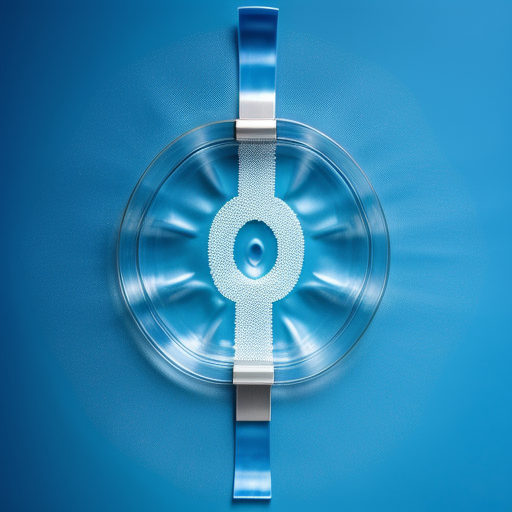

In [8]:
from pipelines.pipeline_default import generate

output_images = generate(
    prompt="A blue bottle",
    uncond_prompt="deform, low quality",
    input_image=img,
    strength=1.0,
    num_per_image=2,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=20,
    seeds=[42,53],
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.5
)

output_images[0]

## Pipeline inpainting

In [9]:
from PIL import Image
from utils import model_loader

def make_inpaint_data(image_path, mask_path):
    img_pil = Image.open(image_path).convert("RGB")
    mask_pil = Image.open(mask_path).convert("L")
    return img_pil, mask_pil

image_path = "./images/test_image/bottle.jpg"
mask_path = "./images/test_image/bottle_mask.jpg"
input_image, mask = make_inpaint_data(image_path, mask_path)

- Load statedict

In [10]:
kwargs = {"is_inpaint":True}
diffusion_state_dict = torch.load(os.path.join(root_path, "favorfit_inpaint.pth"))

- For LORA

In [11]:
kwargs["is_lora"] = True
lora_state_dict = torch.load(os.path.join(root_path, "lora", "favorfit_lora.pth"))
diffusion_state_dict["lora"] = lora_state_dict

- Load model

In [12]:
models = model_loader.load_diffusion_model(diffusion_state_dict, **kwargs)

- Run

100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


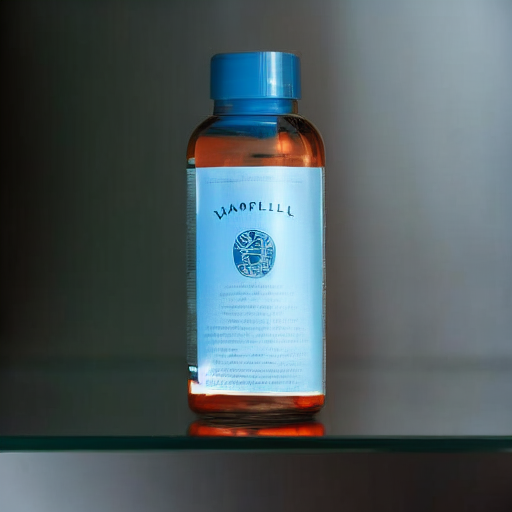

In [13]:
from pipelines.pipeline_inpainting import generate

output_images = generate(
    prompt="blue bottle on grassland",
    uncond_prompt="deform, low quality",
    input_image=input_image,
    mask_image=mask,
    num_per_image=2,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42, 52],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=1.0
)


output_images[0]

## Pipeline default controlnet

In [14]:
from PIL import Image
from utils import model_loader
input_image = Image.open("./images/test_image/bottle.jpg").convert("RGB")
control_image = Image.open("./images/dog_bad_sr.png").convert("RGB").resize((512,512))

- Load statedict

In [15]:
kwargs = {"is_controlnet":True}
diffusion_state_dict = torch.load(os.path.join(root_path, "favorfit_base.pth"))

- For LORA

In [16]:
kwargs["is_lora"] = True
lora_state_dict = torch.load(os.path.join(root_path, "lora", "favorfit_lora.pth"))
diffusion_state_dict["lora"] = lora_state_dict

- Load model

In [17]:
models = model_loader.load_diffusion_model(diffusion_state_dict, **kwargs)

- Load controlnet

In [18]:
control_state_dict = torch.load(os.path.join(root_path, "controlnet", "outpaint_v2.pth"))
controlnet = model_loader.load_controlnet_model(control_state_dict)
models.update(controlnet)

- Run

100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


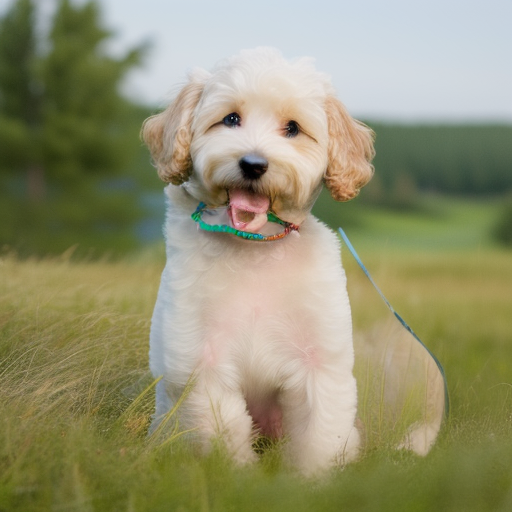

In [19]:
from pipelines.pipline_default_controlnet import generate

output_images = generate(
    prompt="dog on grassland",
    uncond_prompt="deform, low quality",
    input_image=input_image,
    control_image=control_image,
    num_per_image=1,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=1.0,
    controlnet_scale=0.5
)


output_images[0]

## Pipeline inpainting controlnet

In [20]:
from PIL import Image
from utils import model_loader

def make_inpaint_data(image_path, mask_path):
    img_pil = Image.open(image_path).convert("RGB")
    mask_pil = Image.open(mask_path).convert("L")
    return img_pil, mask_pil

image_path = "./images/test_image/bottle.jpg"
mask_path = "./images/test_image/mask.png"
input_image, mask = make_inpaint_data(image_path, mask_path)
control_image = Image.open("./images/dog_bad_sr.png").convert("RGB").resize((512,512))

- Load statedict

In [21]:
kwargs = {"is_inpaint":True, "is_controlnet":True}
diffusion_state_dict = torch.load(os.path.join(root_path, "favorfit_inpaint.pth"))

- For LORA

In [22]:
kwargs["is_lora"] = True
lora_state_dict = torch.load(os.path.join(root_path, "lora", "favorfit_lora.pth"))
diffusion_state_dict["lora"] = lora_state_dict

- Load model

In [23]:
models = model_loader.load_diffusion_model(diffusion_state_dict, **kwargs)

- Load controlnet

In [24]:
control_state_dict = torch.load(os.path.join(root_path, "controlnet", "outpaint_v2.pth"))
controlnet = model_loader.load_controlnet_model(control_state_dict)
models.update(controlnet)

- Run

100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


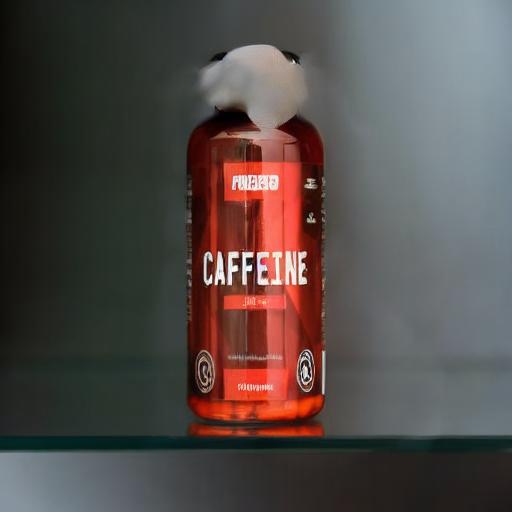

In [25]:
from pipelines.pipeline_inpainting_controlnet import generate

output_images = generate(
    prompt="dog on grassland",
    uncond_prompt="deform, low quality",
    input_image=input_image,
    mask_image=mask,
    control_image=control_image,
    num_per_image=2,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42, 52],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=1.0
)


output_images[0]

## Pipeline reference

In [6]:
from PIL import Image
from utils import model_loader
input_image = Image.open("./images/test_image/bottle.jpg").convert("RGB")
control_image = Image.open("./images/dog_bad_sr.png").convert("RGB").resize((512,512))

- Load statedict

In [7]:
kwargs = {"is_controlnet":True, "is_lora":True, "clip_image_encoder":True, "clip_dtype":torch.float16}
diffusion_state_dict = torch.load(os.path.join(root_path, "favorfit_base.pth"))

- For LORA

In [8]:
kwargs["is_lora"] = True
lora_state_dict = torch.load(os.path.join(root_path, "lora", "favorfit_lora.pth"))
diffusion_state_dict["lora"] = lora_state_dict

- Load model

In [9]:
models = model_loader.load_diffusion_model(diffusion_state_dict, **kwargs)

2024-02-04 17:27:44.884821: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-04 17:27:44.885703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 17:27:44.900585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 17:27:45.195482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


- Load controlnet

In [10]:
control_state_dict = torch.load(os.path.join(root_path, "controlnet", "outpaint_v2.pth"))
controlnet = model_loader.load_controlnet_model(control_state_dict)
models.update(controlnet)

- Run

100%|██████████| 16/16 [00:02<00:00,  6.49it/s]


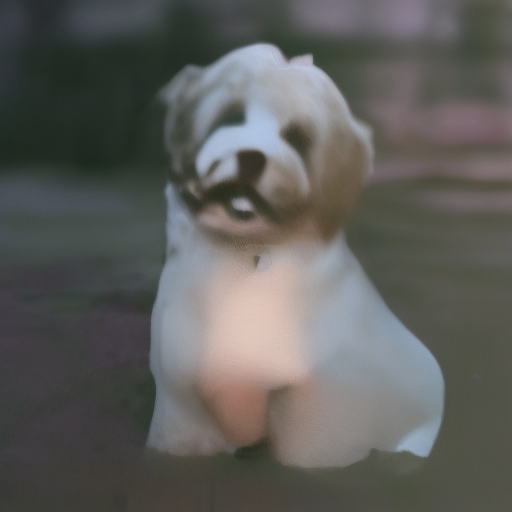

In [11]:
from pipelines.pipeline_reference import generate

output_images = generate(
    ref_image=control_image,
    unref_image=control_image,
    input_image=input_image,
    control_image=control_image,
    num_per_image=2,
    strength=0.8,
    do_cfg=False,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    models=models,
    seeds=[42, 52],
    device=DEVICE,
    idle_device="cpu",
    lora_scale=1.0,
    controlnet_scale=1.0,
)

output_images[0]